# Introduction

Here I test the idea of binary, or very discrete, coding in an adaption of Larry Abbott's FORCE learning [0]. 

I want to make sense of a world where the neural code is binary [6] (or very discrete) but organisms must still make smooth regular movements, and have conitnous feeling thoughts. A coarse code and a smooth world seem, naively, to contradict. I started playing with FORCE really out of curiosity, and because of all the learning rules I know it was the least likely to work! And then it work really well. ....Science! I'm surprised and pleased that my adaption, discrete FORCE, or DFORFCE, works so well.

While the learing part of FORCE is not biologically plausible (Recursive least squares, at least as implemented here), keys ideas do have theoretical and empirical support. FORCE uses the idea of high dimensional random (non-)linear encoding tied to linear decoding, which is found in all the 'echo state' and 'liquid state' learning systems (google for more) and which seem to be supported by data from visual areas[1], and motor cortex [3], among other areas [5]. Separately, Nengo/NEF also used non-linear/linear methods to make SPAUN [4].

### Relevant Papers

* [0] **Original FORCE learning paper**
    * Sussillo D, Abbott LF (2009). [Generating coherent patterns of activity from chao*tic neural networks](http://dx.doi.org/10.1016/j.neuron.2009.07.018). *Neuron*. 63(4):544-57

* [1] **Application of recurrent neural network learning to model dynamics in primate visual cortex**
    * Mante V, Sussillo D, Shenoy KV, Newsome WT (2013). [Context-dependent computation by recurrent dynamics in prefrontal cortex](http://dx.doi.org/10.1038/nature12742). *Nature*. 503(7474):78-84.
       
* [2] **How recurrent neural networks respond to sinusoidal input**
    * Rajan K, Abbott LF, Sompolinsky H (2010). [Stimulus-Dependent Suppression of Chaos in Recurrent Neural Networks](http://neurotheory.columbia.edu/~larry/RajanNIPS10.pdf). *Phys. Rev. E* 82:011903.
    
* [3] **Motor movement and dynamics** 
    * Shenoy, Sahani, and Churchland (2013) [Cortical Control of Arm Movements: A Dynamical Systems Perspective](http://www.annualreviews.org/doi/pdf/10.1146/annurev-neuro-062111-150509) *Annual Review of Neuroscience* Vol. 36: 337-359

* [4] **SPAUN, a real big functional 'brain' model**
    * Eliasmith et al (2012) [A Large-Scale Model of the Functioning Brain](http://www.sciencemag.org/content/338/6111/1202.full.pdf) *Science* 338(6111):1202-1205

* [5] **Reservoir computing and reinforcement learning**
     * Bernacchia A, Seo H, Lee D, Wang X-J (2011) [A reservoir of time constants for memory traces in cortical neurons](http://www.cns.nyu.edu/wanglab/publications/pdf/bernacchia.nn2011.pdf) *Nature Neurosci.*, 14: 366-372 
     
* [6] **Evidence for discrete decisions** 
    * Latimer KL, Yates JL, Meister MLR, Huk AC, & Pillow JW (2015). [Single-trial spike trains in parietal cortex reveal discrete steps during decision-making](http://science.sciencemag.org/cgi/pmidlookup?view=long&pmid=26160947) Science 349(6244): 184-187

In [1]:
import pylab as plt
import numpy as np
%matplotlib inline
from __future__ import division
from scipy.integrate import odeint,ode
from numpy import zeros,ones,eye,tanh,dot,outer,sqrt,linspace,cos,pi,hstack,zeros_like,abs,repeat
from numpy.random import uniform,normal,choice
%config InlineBackend.figure_format = 'retina'

## FORCE

FORCE is a variant 'liquid state machine' or 'echo state machine' supervised learning system, that can tame chaotic patterns to match a target time series. Read [0] before you go any farther.

In the model neurons here are replaced `units`, or neural mass models, that represent the aggregrate firing rates of many neurons. This is a common, and useful, theoretical abstraction, in case you're not familiar with it.

First I'm going to show you classic (continous) FORCE, the my discerte version.

### Neural masses

We simulate the model:

$$\frac{d\mathbf{x}}{dt} = -\mathbf{x} + g J \tanh{[\mathbf{x}]} $$

with $x \in \mathcal{R}^N$ (vector), $J \in \mathcal{R}^{N \times N}$ (matrix), $g \in \mathcal{R}$ (scalar). Randomly draw each element of $J$ from a Gaussian distribution with zero mean and variance $1/N$. Characterize the output of the system for increasing values of $g$. If $g$ is greater than 1.5 the system will behave chaotically. If you take $g$ = 1 it reduces the system from FORCE to a tradtional 'echo state' system.

* Here's an example of what the firing of 10 random units looks like:

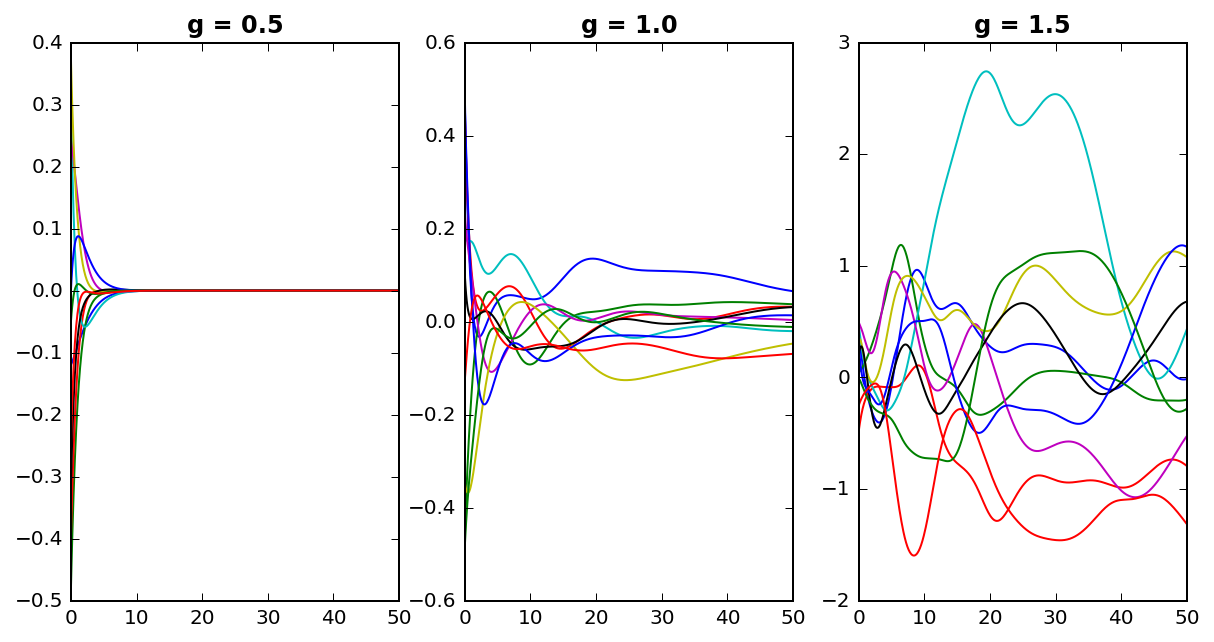

In [2]:
def f1(x,t0):
    return -x + g*dot(J,tanh(x))

N = 500
J = normal(0,sqrt(1/N),(N,N))
x0 = uniform(-0.5,0.5,N)
t = linspace(0,50,500)

plt.figure(figsize=(10,5))
for s,g in enumerate(linspace(0.5,1.5,3)):
    plt.subplot(1,3,s+1)
    x = odeint(f1,x0,t)
    plt.plot(t,x[:,choice(N,10)])
    plt.title('g = '+str(g),fontweight='bold')
plt.show()

#### The loss function

You can linearly reweight the chaos into doing very useful computation. We call this learner the readout readout unit.

Model an output or readout unit for the network as:

$$z = \mathbf{w}^T \tanh[\mathbf{x}]$$

The output $z$ is a scalar formed by the dot product of two N-dimensional vectors ($\mathbf{w}^T$ denotes the transpose of $\mathbf{w}$). We will implement the FORCE learning rule [(Susillo & Abbott, 2009)](http://dx.doi.org/10.1016/j.neuron.2009.07.018), by adjusting the readout weights, $w_i$, so that $z$ matches a target function:

$$f(t) = \cos\left(\frac{2 \pi t}{50} \right)$$

The rule works by implementing [recursive least-squares](https://www.youtube.com/watch?v=gHSiFqO23TE):

$$\mathbf{w} \rightarrow \mathbf{w} + c(f-z) \mathbf{q}$$

$$\mathbf{q} = P \tanh [\mathbf{x}]$$

$$c = \frac{1}{1+ \mathbf{q}^T \tanh(\mathbf{x})}$$

$$P_{ij} \rightarrow P_{ij} - c q_i q_j$$

### Real FORCE

Let's teach the chaos how to be a sin wave

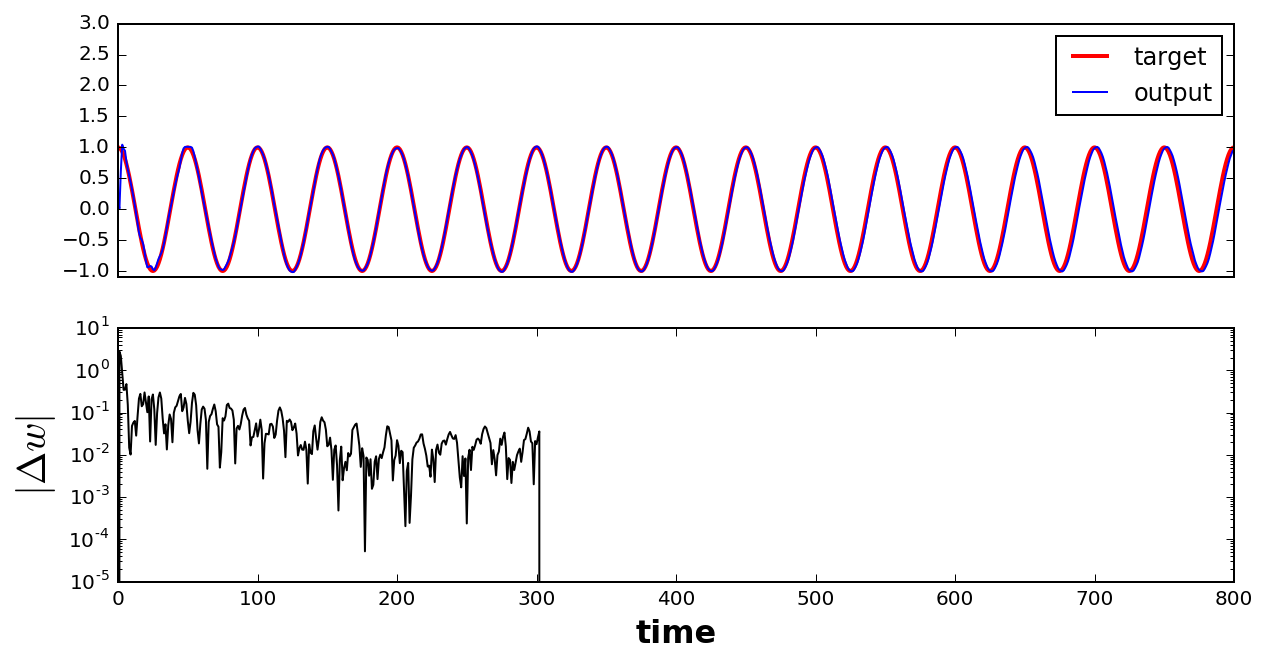

In [25]:
target = lambda t0: cos(2 * pi * t0 / 50)  # target pattern

def f3(t0, x, tanh_x):
    return -x + g * dot(J, tanh_x) + dot(w, tanh_x) * u

dt = 1       # time step
tmax = 800   # simulation length
tstop = 300

N = 300
J = normal(0, sqrt(1 / N), (N, N))
x0 = uniform(-0.5, 0.5, N)

g = 1.5
u = uniform(-1, 1, N)
w = uniform(-1 / sqrt(N), 1 / sqrt(N), N)  # initial weights
P = eye(N)  # Running estimate of the inverse correlation matrix
lr = 1.0  # learning rate

# simulation data: state, output, time, weight updates
x, z, t, wu = [x0], [], [0], [0]

# Set up ode solver
solver = ode(f3)
solver.set_initial_value(x0)

# Integrate ode, update weights, repeat
while t[-1] < tmax:
    tanh_x = tanh(x[-1])  # cache
    z.append(dot(w, tanh_x))
    error = target(t[-1]) - z[-1]
    q = dot(P, tanh_x)
    c = lr / (1 + dot(q, tanh_x))
    P = P - c * outer(q, q)
    w = w + c * error * q

    # Stop leaning here
    if t[-1] > tstop:
        lr = 0

    solver.set_f_params(tanh_x)
    wu.append(np.sum(np.abs(c * error * q)))

    solver.integrate(solver.t + dt)
    x.append(solver.y)
    t.append(solver.t)

# last update for readout neuron
z.append(dot(w, tanh_x))

x = np.array(x)
t = np.array(t)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(t, target(t), '-r', lw=2)
plt.plot(t, z, '-b')
plt.legend(('target', 'output'))
plt.ylim([-1.1, 3])
plt.xticks([])
plt.subplot(2, 1, 2)
plt.plot(t, wu, '-k')
plt.yscale('log')
plt.ylabel('$|\Delta w|$', fontsize=20)
plt.xlabel('time', fontweight='bold', fontsize=16)
plt.show()

FORCE does a pretty nice job learning how to be a sin wave. If you rerun this a few times, you'll see the quality of the fits varies. Such if woring with randomness and chaos.

### Binary FORCE

#### Implementation

I first define a function that converts unit rates into a binary output. Then I replace the standard learning FORCE math to use the binary decoded response generated by this function.

In [19]:
def decode(x, rho):
    xd = zeros_like(x)
    
    xd[x > rho] = 1
    xd[x < -rho] = -1
    
    return xd

* Here's when the binary version looks like. I use random (`U`) selected thresholds to convert from rates to binary codes. Don't have any idea how this really works, so random seems as good a guess as any.
* That said a fixed threshold seems just as good.
* I'm curious as to whether different thresholds for different training targets might let me multiplex many decodings onto the same pool?

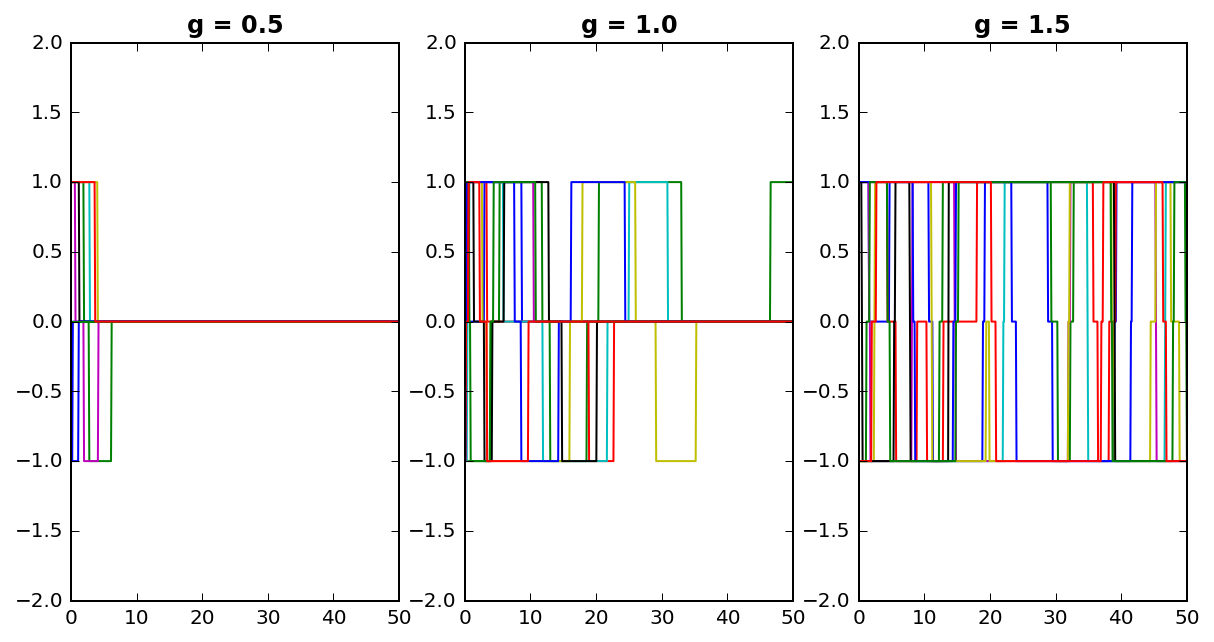

In [20]:
def f1(x,t0):
    return -x + g*dot(J,tanh(x))

N = 500
J = normal(0,sqrt(1/N),(N,N))
x0 = uniform(-0.5,0.5,N)
t = linspace(0,50,500)

rho = uniform(0,0.1,N)  # Rand thresholds!
# rho = 0.5  # fixed threshold!

plt.figure(figsize=(10,5))
for s,g in enumerate(linspace(0.5,1.5,3)):
    plt.subplot(1,3,s+1)
    x = odeint(f1,x0,t)
    xd = decode(x, rho)
    plt.plot(t,xd[:,choice(N,10)])
    plt.title('g = '+str(g),fontweight='bold')
    plt.ylim(-2,2)
plt.show()

#### The binary loss function

Now let's learn, with binary codes.

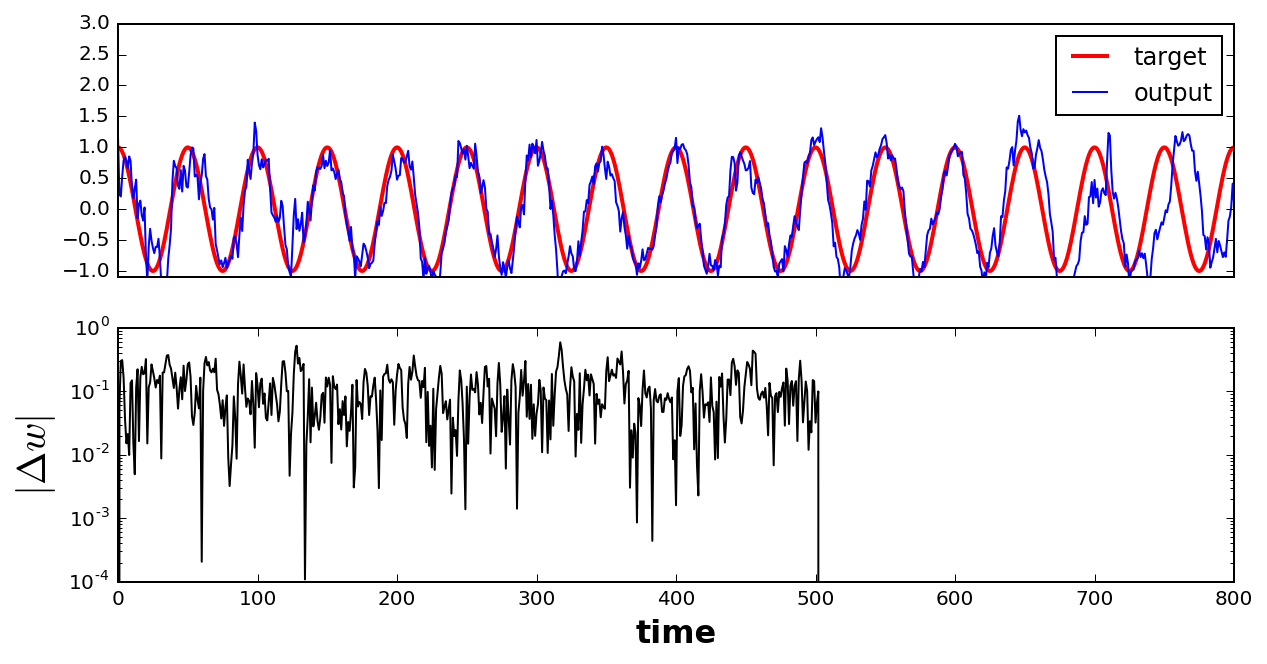

In [27]:
target = lambda t0: cos(2 * pi * t0 / 50)  # target pattern


def f3(t0, x):
    return -x + g * dot(J, tanh_x) + dot(w, tanh_x) * u

dt = 1       # time step
tmax = 800   # simulation length
tstop = 500

N = 300
J = normal(0, sqrt(1 / N), (N, N))
x0 = uniform(-0.5, 0.5, N)
g = 1.5
u = uniform(-1, 1, N)
w = uniform(-1 / sqrt(N), 1 / sqrt(N), N)  # initial weights
P = eye(N)  # Running estimate of the inverse correlation matrix
lr = .4  # learning rate

rho = repeat(0.05, N)

# simulation data: state,
# output, time, weight updates
x, z, t, wu = [x0], [], [0], [0]

# Set up ode solver
solver = ode(f3)
solver.set_initial_value(x0)

# Integrate ode, update weights, repeat
while t[-1] < tmax:
    tanh_x = tanh(x[-1])
    tanh_xd = decode(tanh_x, rho)  # BINARY CODE INTRODUCED HERE!
    z.append(dot(w, tanh_xd))

    error = target(t[-1]) - z[-1]
    q = dot(P, tanh_xd)
    c = lr / (1 + dot(q, tanh_xd))
    P = P - c * outer(q, q)
    w = w + c * error * q

    # Stop training time
    if t[-1] > tstop:
        lr = 0

    wu.append(np.sum(np.abs(c * error * q)))

    solver.integrate(solver.t + dt)
    x.append(solver.y)
    t.append(solver.t)

# last update for readout neuron
z.append(dot(w, tanh_x))

# plot
x = np.array(x)
t = np.array(t)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(t, target(t), '-r', lw=2)
plt.plot(t, z, '-b')
plt.legend(('target', 'output'))
plt.ylim([-1.1, 3])
plt.xticks([])
plt.subplot(2, 1, 2)
plt.plot(t, wu, '-k')
plt.yscale('log')
plt.ylabel('$|\Delta w|$', fontsize=20)
plt.xlabel('time', fontweight='bold', fontsize=16)
plt.show()

* Besides some small fluctations, the binary version does nearly as well as the real valued version above!
* I need to quantify performance differences between the two models and,
* need to train with many more kinds of inputs to be sure (ideally reproduce the orginal paper, at minimum) but
* I think DFORCE might be kind of big deal, or at least of interest to folks as more evidience for discrete coding starts to surface (as I've heard rumblings is/may happen).